# Carregue as bibliotecas necessárias

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
import json
import matplotlib.pyplot as plt
import numpy as np

## Carregue o conjunto de dados

In [19]:
# Carregue o conjunto de dados gerado a partir do script dataset_generator.py e os separe em data e target
dados = {}
with open("./dataset1.json", "r") as arquivo:
    dados = json.load(arquivo)

data = [(d["coords"]) for d in dados["dados"]]
target = [d["params"] for d in dados["dados"]]

## Normalize os dados

In [20]:
# Converta 'data' para um array bidimensional
data_flattened = [sample for series in data for sample in series]

# Crie uma instância do MinMaxScaler e ajuste aos dados
scaler = MinMaxScaler()
scaler.fit(data_flattened)

# Normalize os dados
data_normalized = [scaler.transform(series) for series in data]

scaler.fit(target)

# Normalize os rótulos
target_normalized = scaler.transform(target)

## Separe os dados em treino e teste

In [4]:
test_size = 0.2  # 20% dos dados para teste
train_data, test_data, train_target, test_target = train_test_split(
    data_normalized, target_normalized, test_size=test_size, random_state=42
)

## Defina a arquitetura da rede neural

In [26]:
# Formato dos dados
num_coords = 128
coord_dim = 2
num_params = 4
# occult_layer = 64
occult_layer = 112
"""
Best trial mse/r2:
  Value: 0.8926983780202556
  Params: 
    'num_layers': 1
    'units_fc_layer_0': 112
    'batch_size': 32
    'epochs': 100
    'learning_rate': 0.001611245074625867
    'num_folds': 12"""


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(num_coords * coord_dim, num_coords)
        self.fc2 = nn.Linear(num_coords, occult_layer)
        self.fcn = nn.Linear(occult_layer, num_params)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fcn(x)
        return x

## Defina parâmetros para o treinamento do modelo

In [25]:
# Defina função de perda e o otimizador
model = NeuralNetwork()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001611245074625867)
num_epochs = 100
batch_size = 32

train_losses = []
val_losses = []
r2_train_values = []
r2_val_values = []

# Treine o modelo com a técnica K-Fold Cross Validation

In [27]:
train_dataset_size = len(train_data)
num_folds = 12
k_fold = KFold(n_splits=num_folds, shuffle=True, random_state=42)


def train_and_validate():

    for fold, (train_indices, val_indices) in enumerate(
        k_fold.split(range(train_dataset_size))
    ):
        # Configure os conjuntos de dados e rótulos
        x_train_set = np.array(Subset(train_data, train_indices))
        y_train_set = np.array(Subset(train_target, train_indices))
        x_val_set = np.array(Subset(train_data, val_indices))
        y_val_set = np.array(Subset(train_target, val_indices))

        x_train_tensor = torch.Tensor(x_train_set)
        y_train_tensor = torch.Tensor(y_train_set)
        x_val_tensor = torch.Tensor(x_val_set)
        y_val_tensor = torch.Tensor(y_val_set)

        train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        running_loss = 0.0
        running_val_loss = 0.0

        # Treine e valide o modelo
        for epoch in range(int(num_epochs / num_folds)):
            model.train()
            all_predictions = []
            all_targets = []

            # Loop de treinamento
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                all_predictions.extend(outputs.cpu().detach().numpy())
                all_targets.extend(batch_y.cpu().detach().numpy())

            train_losses.append(loss.item())

            all_predictions = np.array(all_predictions)
            all_targets = np.array(all_targets)
            r2 = r2_score(all_targets, all_predictions)
            r2_train_values.append(r2)

            # Loop de validação
            model.eval()
            all_predictions = []
            all_targets = []

            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    outputs = model(batch_x)
                    val_loss = criterion(outputs, batch_y)
                    running_val_loss += val_loss.item()
                    all_predictions.extend(outputs.cpu().numpy())
                    all_targets.extend(batch_y.cpu().numpy())
                val_losses.append(val_loss.item())
            all_predictions = np.array(all_predictions)
            all_targets = np.array(all_targets)
            r2 = r2_score(all_targets, all_predictions)
            r2_val_values.append(r2)

        average_train_loss = running_loss / len(train_loader)
        average_val_loss = running_val_loss / len(val_loader)
        print(
            f"Fold: {fold+1}, average_train_loss: {average_train_loss}, average_val_loss: {average_val_loss}"
        )

In [28]:
train_and_validate()

Fold: 1, average_train_loss: 0.36740886784442095, average_val_loss: 0.23907754259804884
Fold: 2, average_train_loss: 0.1197317942329075, average_val_loss: 0.13449207584684095
Fold: 3, average_train_loss: 0.06479519769630354, average_val_loss: 0.06178015097975731
Fold: 4, average_train_loss: 0.042181726281895586, average_val_loss: 0.051003283665825926
Fold: 5, average_train_loss: 0.03864246038922473, average_val_loss: 0.04447057951862613
Fold: 6, average_train_loss: 0.0367001726332566, average_val_loss: 0.03510768210981041
Fold: 7, average_train_loss: 0.03609314062835082, average_val_loss: 0.0447632756549865
Fold: 8, average_train_loss: 0.036617798254946654, average_val_loss: 0.03911603280963997
Fold: 9, average_train_loss: 0.035191533054508596, average_val_loss: 0.03197958238888532
Fold: 10, average_train_loss: 0.031566387082895504, average_val_loss: 0.023490799746165674
Fold: 11, average_train_loss: 0.03091492777204384, average_val_loss: 0.02697322117940833
Fold: 12, average_train_los

In [11]:
# Salve o modelo
path = "modelo_preliminar.pth"
torch.save(model.state_dict(), path)

# Curvas de aprendizado para treino e validação

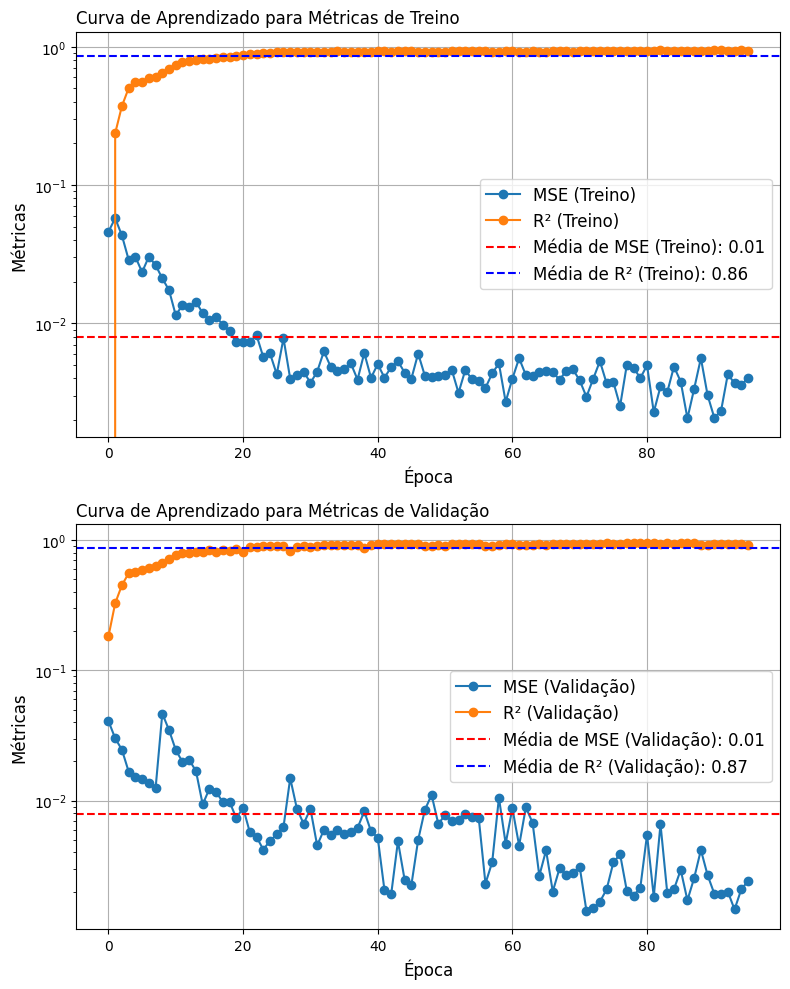

In [29]:
# Criar figura
plt.figure(figsize=(8, 10))

# Gráfico 1 (MSE e R² de Treino)
plt.subplot(2, 1, 1)
plt.plot(
    range(len(train_losses)),
    train_losses,
    marker="o",
    linestyle="-",
    label="MSE (Treino)",
)
plt.plot(
    range(len(r2_train_values)),
    r2_train_values,
    marker="o",
    linestyle="-",
    label="R² (Treino)",
)
plt.xlabel("Época", fontsize=12)
plt.ylabel("Métricas", fontsize=12)
plt.title("Curva de Aprendizado para Métricas de Treino", fontsize=12, loc="left")
plt.yscale("log")  # Escala logarítmica no eixo y para MSE
plt.axhline(
    y=np.mean(train_losses),
    color="r",
    linestyle="--",
    label=f"Média de MSE (Treino): {np.mean(train_losses):.2f}",
)
plt.axhline(
    y=np.mean(r2_train_values),
    color="b",
    linestyle="--",
    label=f"Média de R² (Treino): {np.mean(r2_train_values):.2f}",
)
plt.legend(fontsize=12)
plt.grid(True)

# Gráfico 2 (MSE e R² de Validação)
plt.subplot(2, 1, 2)
plt.plot(
    range(len(val_losses)),
    val_losses,
    marker="o",
    linestyle="-",
    label="MSE (Validação)",
)
plt.plot(
    range(len(r2_val_values)),
    r2_val_values,
    marker="o",
    linestyle="-",
    label="R² (Validação)",
)
plt.xlabel("Época", fontsize=12)
plt.ylabel("Métricas", fontsize=12)
plt.title("Curva de Aprendizado para Métricas de Validação", fontsize=12, loc="left")
plt.yscale("log")  # Escala logarítmica no eixo y para MSE
plt.axhline(
    y=np.mean(val_losses),
    color="r",
    linestyle="--",
    label=f"Média de MSE (Validação): {np.mean(val_losses):.2f}",
)
plt.axhline(
    y=np.mean(r2_val_values),
    color="b",
    linestyle="--",
    label=f"Média de R² (Validação): {np.mean(r2_val_values):.2f}",
)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.savefig("curva_prendizado_metricas_treino_validacao.png")
plt.show()

# Distribuição dos pesos

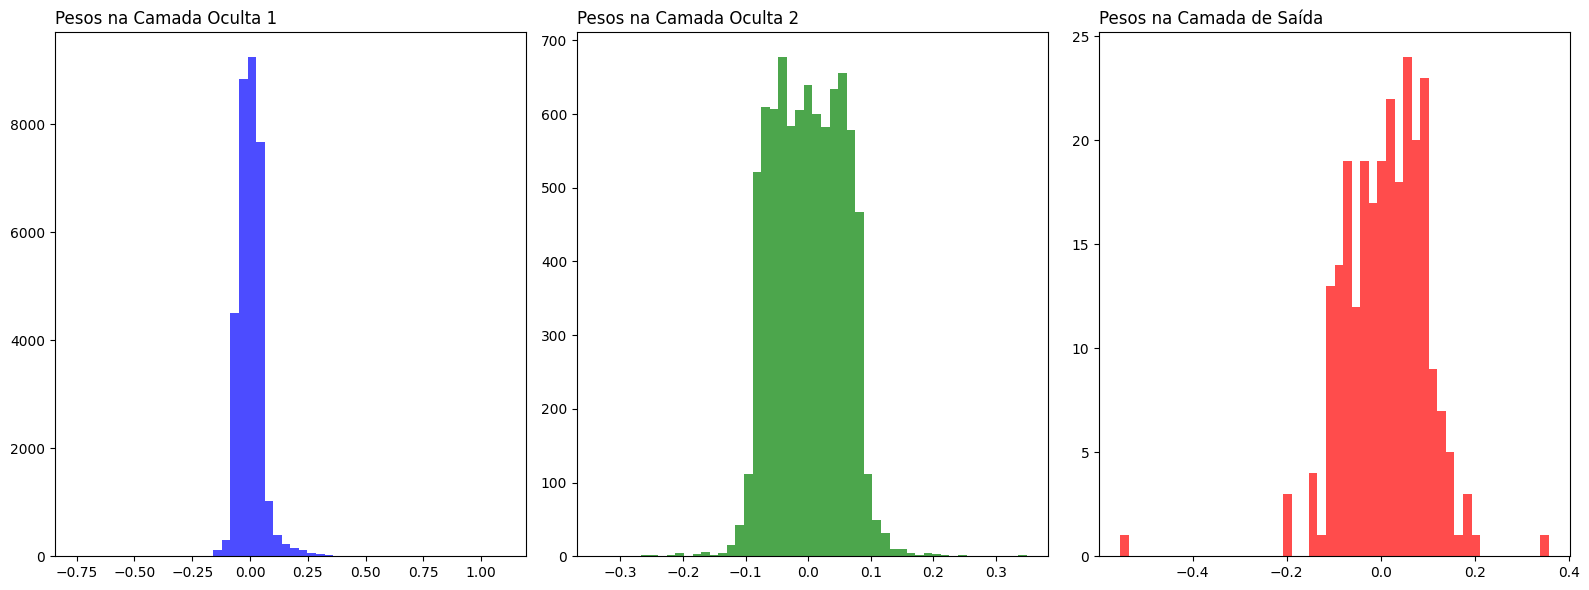

In [30]:
pesos_fc1 = model.fc1.weight.data.numpy().flatten()
pesos_fc2 = model.fc2.weight.data.numpy().flatten()
pesos_fcn = model.fcn.weight.data.numpy().flatten()

plt.figure(figsize=(16, 6))

# Gráfico 1
plt.subplot(1, 3, 1)
plt.hist(pesos_fc1, bins=50, color="blue", alpha=0.7)
plt.title("Pesos na Camada Oculta 1", loc="left")

# Gráfico 2
plt.subplot(1, 3, 2)
plt.hist(pesos_fc2, bins=50, color="green", alpha=0.7)
plt.title("Pesos na Camada Oculta 2", loc="left")

# Gráfico 3
plt.subplot(1, 3, 3)
plt.hist(pesos_fcn, bins=50, color="red", alpha=0.7)
plt.title("Pesos na Camada de Saída", loc="left")

plt.tight_layout()
plt.savefig("pesosOld.png")
plt.show()

## Avalie o modelo com os dados de teste

In [31]:
x_test_tensor = torch.Tensor(np.array(test_data))
y_test_tensor = torch.Tensor(np.array(test_target))

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model.eval()
test_loss = 0.0
test_losses = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        test_loss += criterion(outputs, batch_y).item()
        test_losses.append(criterion(outputs, batch_y).item())

average_test_loss = test_loss / len(test_loader)
print(f"average_test_loss: {average_test_loss}")

average_test_loss: 0.004729321426046746


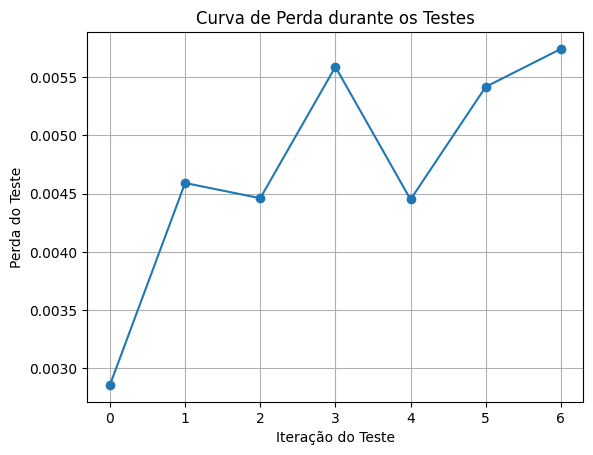

In [32]:
# Plote a curva de perda durante os testes
plt.plot(test_losses, marker="o", linestyle="-")
plt.xlabel("Iteração do Teste")
plt.ylabel("Perda do Teste")
plt.title("Curva de Perda durante os Testes")
plt.grid(True)
plt.show()

# Teste novos dados

In [35]:
with open("./test11.json", "r") as arquivo:
    dados = json.load(arquivo)

pontos = [(d["coords"]) for d in dados["dados"]][0]
params = [d["params"] for d in dados["dados"]]

scaler.fit(pontos)

pontos_n = scaler.transform(pontos)


pontos_tensor = torch.Tensor(pontos_n)

previsao = model(pontos_tensor.unsqueeze(0))


def calcula_mse(predictions, labels):
    mse = ((predictions - labels) ** 2).mean()
    return mse.item()


scaler.fit(target)
oParams = scaler.transform(params)

mse = calcula_mse(previsao.detach().numpy(), oParams)
print(f"MSE: {mse:.4f}")

MSE: 0.0212


# Compare visualmente a previsão com o dado orignal

In [36]:
# Função para gerar o gráfico
def plot_grafico(linhas, new_data, ax, titulo):
    # Defina o tamanho do gráfico
    x_min, x_max = 0, 6000
    y_min, y_max = 0, 8
    dmin, dmax = linhas[2], linhas[3]
    tl, th = linhas[0], linhas[1]

    x_line = [[x_min, dmin, dmin, dmax, dmax, x_max]]

    y_line = [[tl, tl, th, th, tl, tl]]

    ax.plot(x_line[0], y_line[0], color="red")

    ax.scatter([x[0] for x in new_data], [y[1] for y in new_data], c="blue")

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(titulo, loc="left")

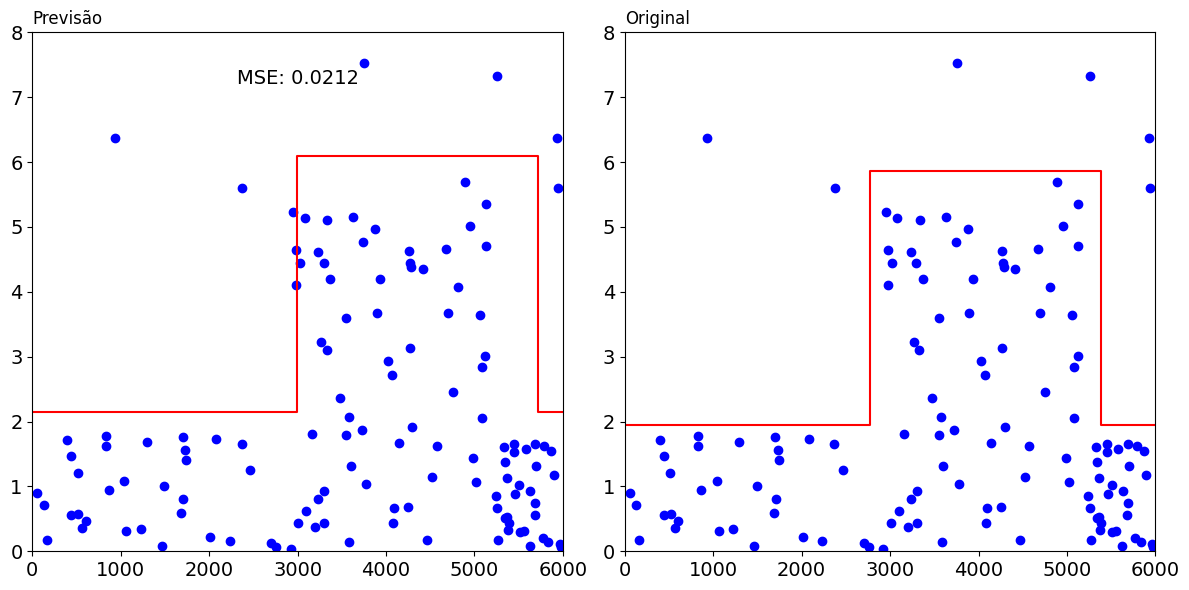

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Converta a previsão para coordenadas no gráfico
scaler.fit(target)
previsao_c = scaler.inverse_transform(previsao.detach().numpy())
linhas = previsao_c.tolist()[0]
plot_grafico(linhas, pontos, axs[0], "Previsão")
axs[0].text(
    0.5, 0.9, f"MSE: {mse:.4f}", transform=axs[0].transAxes, ha="center", fontsize=14
)
plot_grafico(params[0], pontos, axs[1], "Original")
for ax in axs:
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.set_title(ax.get_title(), fontsize=14)
plt.savefig("comparação_previsao_original.png")
plt.tight_layout()
plt.show()